# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we will use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, we'll train an image classifier to recognize different species of flowers. We can imagine using something like this in a phone app that tells us the name of the flower our camera is looking at. In practice we will train this classifier, then export it for use in our application. We'll be using the dataset of 102 flower categories, you can see a few examples below. 

<img src='Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content



When we've completed this project, we will have an application that can be trained on any set of labeled images. Here our network will be learning about flowers and end up as a command line application.  

First up is importing the packages we will need.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


import matplotlib.pyplot as plt
from torchvision import datasets, transforms

import torchvision.models as models

from collections import OrderedDict
from PIL import Image
from matplotlib.ticker import FormatStrFormatter
import json

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets

# Data Transforms for train set
data_transforms_train = transforms.Compose([transforms.RandomRotation(35),
                                            transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])])



# Data Transforms for validation set
data_transforms_validation = transforms.Compose([transforms.Resize(256),
                                                 transforms.CenterCrop(224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                                      [0.229, 0.224, 0.225])])

# Data Transforms for test set
data_transforms_test = transforms.Compose([transforms.Resize(256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder 
# For Training data
train_data = datasets.ImageFolder(train_dir, transform = data_transforms_train)

# For Validation Data
val_data = datasets.ImageFolder(valid_dir, transform = data_transforms_validation)

# For Test Data
test_data = datasets.ImageFolder(test_dir, transform = data_transforms_test)


# TODO: Using the image datasets and the transforms, define the dataloaders
# Define for train data
trainLoaders = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True)

# Define for validation data
valLoaders = torch.utils.data.DataLoader(val_data, batch_size = 32, shuffle = True)

# Define for test data
testLoaders = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle = True )

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [6]:
## TODO: Build and train your network
# List of deep learning pre-trained model
model_algos = {"vgg16": 25088,
         "alexnet": 9216 ,
         "densenet121": 1024}

In [7]:
# Define a function
def model_setup(mod = "vgg16", dropout = 0.5, hidden_layer1 = 150, lr = 0.001):
    # lr -> learning rate
    # mod -> select the deep learning pre-trained model you want to use


    if mod == 'vgg16':
        model = models.vgg16(pretrained = True)

    elif mod == 'alexnet':
        model = models.alexnet(pretrained = True)

    elif mod == 'densenet121':
        model = models.densenet121(pretrained = True)

    else:
        print(f""" {mod} is not  a valid model. Please select from the following model:
                1. vgg16
                2. alexnet
                3. densenet121""")

    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                                ('dropout', nn.Dropout(dropout)),
                                ('input', nn.Linear(model_algos[mod], hidden_layer1)),
                                ('Act_1: relu', nn.ReLU()),
                                ('Hidden_1', nn.Linear(hidden_layer1, 100)),
                                ('Act_2: relu', nn.ReLU()),
                                ('Hidden_2', nn.Linear(100, 60)),
                                ('Act_3: relu', nn.ReLU()),
                                ('Hidden_3', nn.Linear(60, 102)),
                                ('Output', nn.LogSoftmax(dim = 1))
                    ]))

    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr )


    return model, optimizer, criterion

model, optimizer, criterion = model_setup("densenet121")




/Users/drake/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [8]:
#check the model with the changed classifier
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [9]:
# Train the model & check the accuracy on the validation dataset

epochs = 15
print_every = 10
steps = 0
loss_display = []

        
for e in range(epochs):
    running_loss = 0

    for i, (inputs, labels) in enumerate(trainLoaders):
        steps += 1

        optimizer.zero_grad()

        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            model.eval()
            validation_loss = 0
            accuracy = 0

            for i, (inputs2, labels2) in enumerate(valLoaders):
                optimizer.zero_grad()

                with torch.no_grad():
                    outputs2 = model.forward(inputs2)
                    validation_loss = criterion(outputs2, labels2)
                    ps = torch.exp(outputs2).data
                    equality = (labels2.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()

            validation_loss = validation_loss / len(valLoaders)

            accuracy = accuracy / len(valLoaders)

            print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every),
                      "Validation Loss {:.4f}".format(validation_loss),
                      "Accuracy: {:.4f}".format(accuracy))

            running_loss = 0



Epoch: 1/15... Loss: 4.6238 Validation Loss 0.1752 Accuracy: 0.0264
Epoch: 1/15... Loss: 4.6092 Validation Loss 0.1754 Accuracy: 0.0271
Epoch: 1/15... Loss: 4.5620 Validation Loss 0.1739 Accuracy: 0.0252
Epoch: 1/15... Loss: 4.5969 Validation Loss 0.1746 Accuracy: 0.0514
Epoch: 1/15... Loss: 4.4638 Validation Loss 0.1808 Accuracy: 0.0577
Epoch: 1/15... Loss: 4.4275 Validation Loss 0.1736 Accuracy: 0.0793
Epoch: 1/15... Loss: 4.3987 Validation Loss 0.1676 Accuracy: 0.0983
Epoch: 1/15... Loss: 4.2853 Validation Loss 0.1683 Accuracy: 0.0863
Epoch: 1/15... Loss: 4.2019 Validation Loss 0.1687 Accuracy: 0.1295
Epoch: 1/15... Loss: 4.0718 Validation Loss 0.1659 Accuracy: 0.1070
Epoch: 1/15... Loss: 3.9106 Validation Loss 0.1452 Accuracy: 0.1591
Epoch: 1/15... Loss: 3.9344 Validation Loss 0.1309 Accuracy: 0.1891
Epoch: 1/15... Loss: 3.6568 Validation Loss 0.1001 Accuracy: 0.1753
Epoch: 1/15... Loss: 3.5548 Validation Loss 0.1284 Accuracy: 0.2165
Epoch: 1/15... Loss: 3.4532 Validation Loss 0.11

Epoch: 6/15... Loss: 0.7881 Validation Loss 0.0254 Accuracy: 0.7821
Epoch: 6/15... Loss: 0.8749 Validation Loss 0.0440 Accuracy: 0.8018
Epoch: 7/15... Loss: 0.9044 Validation Loss 0.0262 Accuracy: 0.7967
Epoch: 7/15... Loss: 0.9116 Validation Loss 0.0642 Accuracy: 0.8036
Epoch: 7/15... Loss: 0.7442 Validation Loss 0.0167 Accuracy: 0.8145
Epoch: 7/15... Loss: 0.8507 Validation Loss 0.0307 Accuracy: 0.7919
Epoch: 7/15... Loss: 0.8068 Validation Loss 0.0424 Accuracy: 0.7829
Epoch: 7/15... Loss: 1.0244 Validation Loss 0.0196 Accuracy: 0.8058
Epoch: 7/15... Loss: 0.7542 Validation Loss 0.0190 Accuracy: 0.7869
Epoch: 7/15... Loss: 0.6878 Validation Loss 0.0144 Accuracy: 0.7953
Epoch: 7/15... Loss: 0.9439 Validation Loss 0.0421 Accuracy: 0.7942
Epoch: 7/15... Loss: 0.8655 Validation Loss 0.0307 Accuracy: 0.8018
Epoch: 7/15... Loss: 0.8861 Validation Loss 0.0417 Accuracy: 0.7982
Epoch: 7/15... Loss: 0.9552 Validation Loss 0.0595 Accuracy: 0.8011
Epoch: 7/15... Loss: 0.8017 Validation Loss 0.02

Epoch: 12/15... Loss: 0.6373 Validation Loss 0.0213 Accuracy: 0.8467
Epoch: 12/15... Loss: 0.6058 Validation Loss 0.0150 Accuracy: 0.8695
Epoch: 12/15... Loss: 0.5599 Validation Loss 0.0153 Accuracy: 0.8722
Epoch: 12/15... Loss: 0.5982 Validation Loss 0.0070 Accuracy: 0.8618
Epoch: 12/15... Loss: 0.7636 Validation Loss 0.0141 Accuracy: 0.8632
Epoch: 13/15... Loss: 0.5186 Validation Loss 0.0105 Accuracy: 0.8476
Epoch: 13/15... Loss: 0.5334 Validation Loss 0.0179 Accuracy: 0.8623
Epoch: 13/15... Loss: 0.6830 Validation Loss 0.0293 Accuracy: 0.8487
Epoch: 13/15... Loss: 0.7490 Validation Loss 0.0204 Accuracy: 0.8518
Epoch: 13/15... Loss: 0.6002 Validation Loss 0.0170 Accuracy: 0.8482
Epoch: 13/15... Loss: 0.6302 Validation Loss 0.0128 Accuracy: 0.8572
Epoch: 13/15... Loss: 0.5804 Validation Loss 0.0175 Accuracy: 0.8710
Epoch: 13/15... Loss: 0.7109 Validation Loss 0.0117 Accuracy: 0.8659
Epoch: 13/15... Loss: 0.5650 Validation Loss 0.0090 Accuracy: 0.8803
Epoch: 13/15... Loss: 0.5829 Valid

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [25]:
# TODO: Do validation on the test set
def testing_accuracy(testLoaders):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testLoaders:
            images3, labels3  = data
            output3 = model(images3)
            _, predicted = torch.max(output3.data, 1)
            total += labels3.size(0)
            correct += (predicted == labels3).sum().item()

    print("Accuracy for test data: %d %%" % (100*correct/total))

testing_accuracy(testLoaders)

Accuracy for test data: 86 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
# TODO: Save the checkpoint 
model.class_to_idx = train_data.class_to_idx

checkpoint = {'model_algo': 'densenet121',
              'hidden_layer_1': 150,
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx}
torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [9]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(path):
    checkpoint = torch.load(path)
    structure = checkpoint['model_algo']
    hidden_layer1 = checkpoint['hidden_layer_1']
    model_2,_,_ = model_setup(structure , 0.5,hidden_layer1)
    model_2.class_to_idx = checkpoint['class_to_idx']
    model_2.load_state_dict(checkpoint['state_dict'])
    
    return model_2
    


In [10]:
# Load the model
model_2 = load_model('checkpoint.pth')  
print(model_2)

/Users/drake/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [11]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns the image as a tensor
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(image)
   
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    tensor_image = transform(img)
    
    return tensor_image


In [12]:
# Check the above function
test_file = data_dir + '/test' + '/1/' + 'image_06752.jpg'
image = process_image(test_file)
print(image.shape)

torch.Size([3, 224, 224])


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [13]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

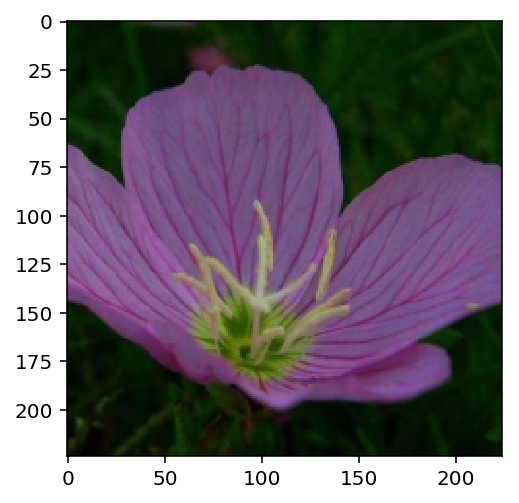

In [14]:
# Run the above function 
imshow(process_image(test_file))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [16]:
model.class_to_idx = train_data.class_to_idx

In [17]:
type(model.class_to_idx)

dict

In [18]:
# Invert the mapping i.e index to class
idx_to_class = {v: k for k, v in model.class_to_idx.items()}

In [19]:
def predict(image_path, model_checkpoint, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    img = process_image(image_path)
    img = img.unsqueeze_(0)
    img = img.float()
    # Load the model from the checkpoint
    mod = load_model(model_checkpoint)
    
    mod.eval()
    with torch.no_grad():
        out = mod.forward(img)
        
    prob = F.softmax(out.data,dim=1)
    
    return prob.topk(topk)    
    
    
    
    

In [20]:
#Check the predict function
probs, classes = predict(test_file, 'checkpoint.pth')

/Users/drake/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [21]:
print(probs, classes)

tensor([[0.8846, 0.0653, 0.0098, 0.0081, 0.0074]]) tensor([[ 0, 53, 87, 34, 84]])


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [22]:
# TODO: Display an image along with the top 5 classes
def sanity_check():
    plt.rcParams["figure.figsize"] = (10,10)
    plt.subplot(211)
    
    index = 1
    path = data_dir + '/test' + '/1/' + 'image_06752.jpg'

    prob = predict(path, 'checkpoint.pth')
    image = process_image(path)

    

    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(cat_to_name[str(index)])
    axs.show()
    
    
    x = np.array(prob[0][0])
    y = [cat_to_name[str(index + 1)] for index in np.array(prob[1][0])]
    
    
    val = float(len(y))
    fig, ax = plt.subplots(figsize=(10,5))
    width = 0.8
    tickLocations = np.arange(val)
    ax.bar(tickLocations, x, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(y)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()


/Users/drake/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


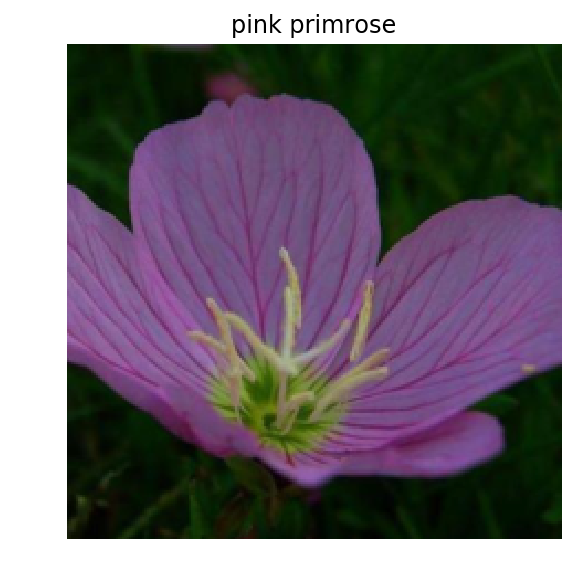

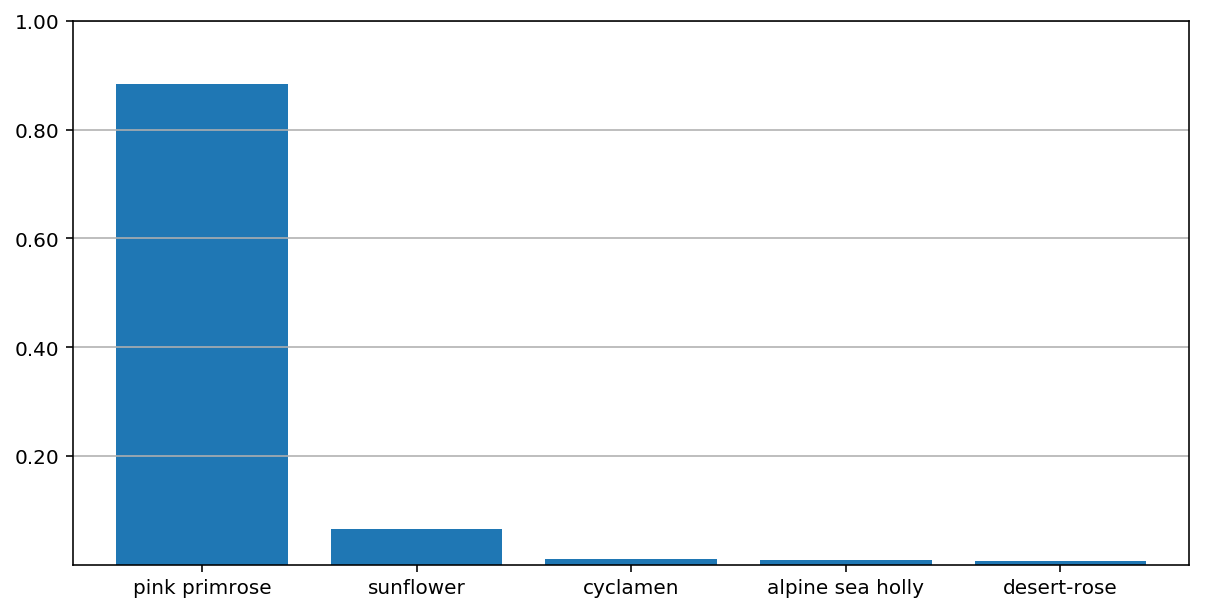

In [23]:
sanity_check()   